In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns

from neurokit2.microstates.microstates_clean import microstates_clean
from package1.tbd import ModKMeansSkstab, scale_data

In [6]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"
processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True)
cleaned = mne.io.read_epochs_eeglab(processed_file)

raw_highpass = raw.copy().filter(l_freq=0.5, h_freq=None)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=40)
raw_down_sampled = raw_lowpass.copy().resample(sfreq=256)

Extracting EDF parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro\sub-001_ses-t1_task-resteyesc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245759  =      0.000 ...   239.999 secs...
Extracting parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned\sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set...
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 339 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


In [8]:
data, indices, gfp, info_mne  = microstates_clean(cleaned.get_data(), standardize_eeg=False, sampling_rate=256)
gfp_peakes = gfp[indices]
new_indices = np.argpartition(gfp_peakes, -3500)[-3500:]
neuro_gfp_data = data[:, indices][:, new_indices]

ValueError: `x` must be a 1-D array

In [ ]:
norms = scale_data(neuro_gfp_data.T, z_score=False)
activation = norms.dot(norms.T)
absolute_cosine_matrix = np.abs(activation)
#np.fill_diagonal(absolute_cosine_matrix, 0)

In [ ]:
cluster = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=8, min_samples=2)
cluster.fit(absolute_cosine_matrix)

HDBSCAN(metric='precomputed', min_cluster_size=8, min_samples=2)

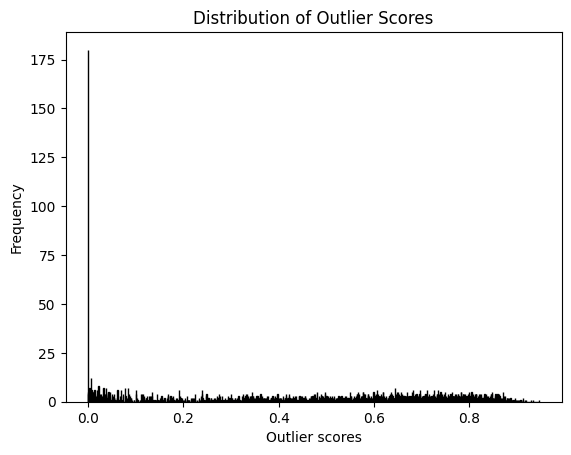

In [ ]:
plt.hist(cluster.outlier_scores_, bins=3500, edgecolor='k')
plt.xlabel('Outlier scores')
plt.ylabel('Frequency')
plt.title('Distribution of Outlier Scores')
plt.show()

In [ ]:
cluster.leaf_size

40

In [ ]:
cluster.cluster_persistence_

array([0.00535918, 0.05109926, 0.        , 0.02134509, 0.05162141,
       0.        , 0.        , 0.02044981, 0.02059491, 0.31477385,
       0.        , 0.1091008 , 0.13203026, 0.        , 0.09340877,
       0.07742071, 0.21969367, 0.11206648, 0.09511747, 0.0299672 ])

<Axes: ylabel='$\\lambda$ value'>

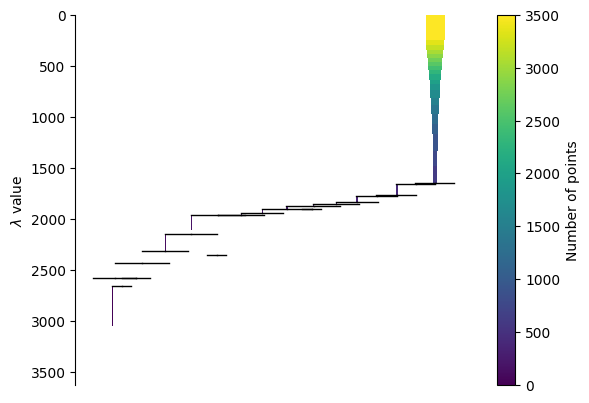

In [ ]:
cluster.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

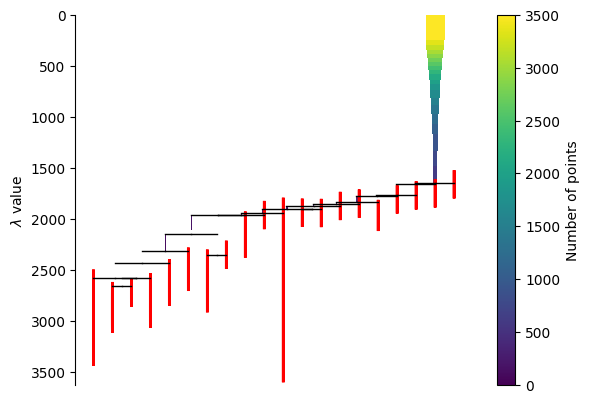

In [ ]:
cluster.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

In [ ]:
g = cluster.condensed_tree_.to_networkx()
g.number_of_nodes()

3539

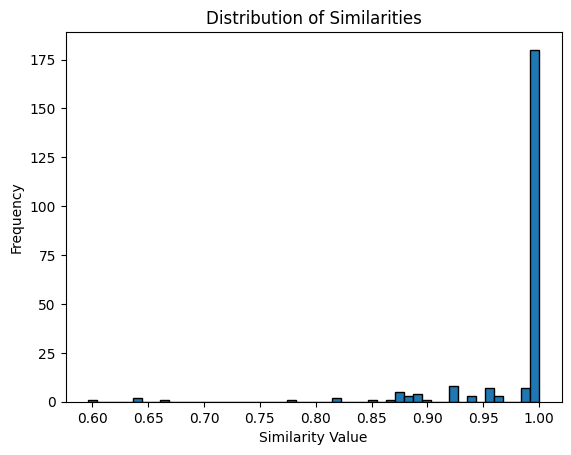

In [ ]:
plt.hist(cluster.probabilities_[np.where(cluster.probabilities_>0)], bins=50, edgecolor='k')
plt.xlabel('Similarity Value')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities')
plt.show()

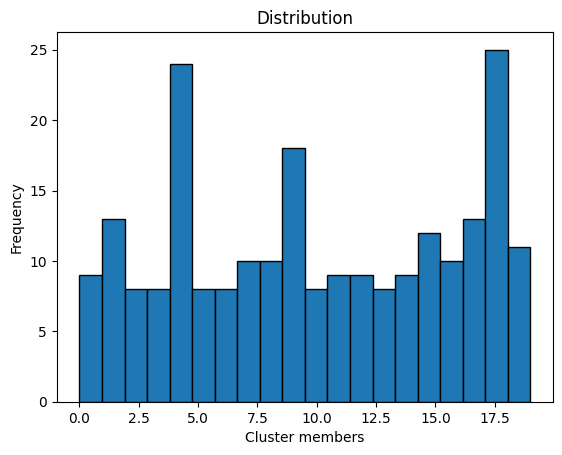

In [ ]:
plt.hist(cluster.labels_[np.where(cluster.labels_>-1)], bins=20, edgecolor='k')
plt.xlabel('Cluster members')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.show()

In [ ]:
mincs = np.arange(30, dtype=int)
minss = np.arange(30, dtype=int)
grid = np.ndarray(shape=[30, 30])

In [ ]:
print(cluster.weighted_cluster_medoid)

<bound method HDBSCAN.weighted_cluster_medoid of HDBSCAN(metric='precomputed', min_cluster_size=8, min_samples=2)>


In [ ]:
for i in range(30):
    for j in range(30):
        clusterG = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=(mincs[i]+2), min_samples=(minss[j]+2), gen_min_span_tree=True)
        clusterG.fit(absolute_cosine_matrix)
        grid[i][j] = clusterG.relative_validity_


c:\Users\Gulbr\MasterOppgave\Code\masteroppgave2\env\lib\site-packages\hdbscan\hdbscan_.py:1429: UserWarning: No raw data is available; this may be due to using a precomputed metric matrix. No minimum spanning tree will be provided without raw data.
  warn(


AttributeError: 'NoneType' object has no attribute 'to_pandas'